In [ ]:
import ssl
import pandas as pd
import numpy as np
import urllib.request

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c gan-getting-started


 98% 358M/367M [00:03<00:00, 53.0MB/s]
100% 367M/367M [00:03<00:00, 112MB/s] 


In [ ]:
! unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dir_path = r"photo_jpg"
def load_images(folder_path, img_size = (128, 128)):
    X = []
    limit = 10000
    for img_name in tqdm(os.listdir(folder_path)[:limit]):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:,:,::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)

img_size = 64
X_train = load_images(dir_path, (img_size, img_size))
X_train.shape

100%|██████████| 7038/7038 [00:09<00:00, 762.46it/s]


(7038, 64, 64, 3)

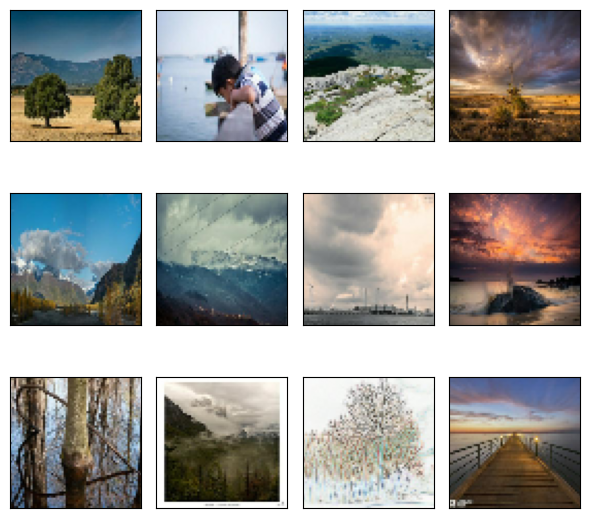

In [ ]:
def show_images(images, title = None):
    plt.figure(figsize = (6, 6))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()
show_images(X_train)

In [ ]:
learning_rate = 0.0003
KL_coef = 0.0075
latent_dim = 64
batch_size = 100

In [ ]:
class VariationalAutoencoder(Model):
    def __init__(self, latent_dim = latent_dim):
        super().__init__()
        self.encoder = Sequential([
            layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Flatten(),
            layers.Dense(2048),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])

        self.get_mean = layers.Dense(latent_dim)
        self.get_logvar = layers.Dense(latent_dim)

        self.decoder = Sequential([
            layers.Dense(2048),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Dense(256 * 8 * 8),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Reshape((8, 8, 256)),

            layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(32, kernel_size = (3, 3), strides = 2, padding = 'same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'sigmoid'),
        ])

    def vae_loss(self, reconstructions, inputs, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(tf.square(reconstructions - inputs))
        kl_loss = -KL_coef * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + kl_loss
        return kl_loss, reconstruction_loss, total_loss

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def sample(self, mean, logvar):
        eps = tf.random.normal(tf.shape(mean))
        return mean + tf.exp(logvar) * eps

    def call(self, x):
        encoded = self.encode(x)
        mean, logvar = self.get_mean(encoded), self.get_logvar(encoded)
        latent_space = self.sample(mean, logvar)
        decoded = self.decode(latent_space)
        return mean, logvar, decoded

    def train_step(self, batch):
        with tf.GradientTape() as tape:
            mean, logvar, y_pred = self.call(batch)
            kl_loss, reconstruction_loss, loss = self.vae_loss(y_pred, batch, mean, logvar)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'kl_loss' : kl_loss, 'reconstruction_loss': reconstruction_loss, 'total_loss' : loss}



In [ ]:
model = VariationalAutoencoder()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))

In [ ]:
fixed_noise = tf.random.normal((60, latent_dim))

model.fit(X_train, epochs = 1)

220/220 [==============================] - 425s 2s/step - kl_loss: 0.0037 - reconstruction_loss: 0.0187 - total_loss: 0.0224


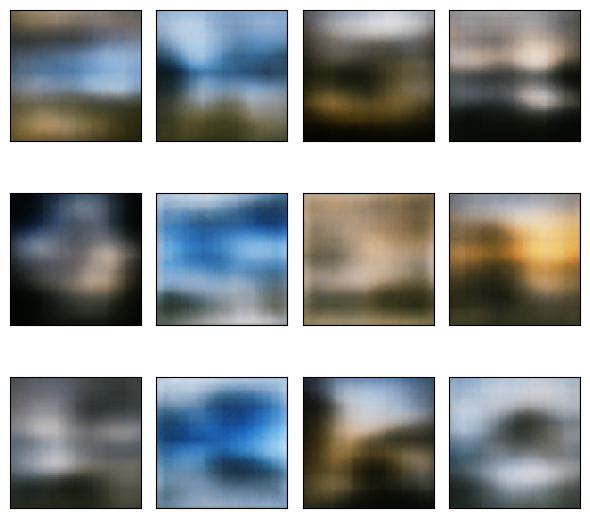

In [ ]:
y_pred = model.decode(fixed_noise)
show_images(y_pred)



In [ ]:


y_pred

<tf.Tensor: shape=(60, 64, 64, 3), dtype=float32, numpy=
array([[[[0.41240057, 0.41207042, 0.36542946],
         [0.4339764 , 0.38959318, 0.33163315],
         [0.4304103 , 0.3949017 , 0.342717  ],
         ...,
         [0.384263  , 0.38145438, 0.35773197],
         [0.3745299 , 0.3702975 , 0.36501744],
         [0.3763018 , 0.39440724, 0.37737027]],

        [[0.40790907, 0.40281194, 0.30971238],
         [0.4534729 , 0.37926853, 0.30150053],
         [0.45439732, 0.40708983, 0.30664366],
         ...,
         [0.38927752, 0.38151705, 0.3520232 ],
         [0.38394457, 0.38803425, 0.35355768],
         [0.3874391 , 0.39343786, 0.37636086]],

        [[0.39850682, 0.37076014, 0.3108665 ],
         [0.4440707 , 0.3752711 , 0.29704258],
         [0.44822082, 0.38388476, 0.29223162],
         ...,
         [0.40632603, 0.3863006 , 0.35712227],
         [0.3862071 , 0.37278885, 0.3525188 ],
         [0.39187413, 0.39085495, 0.35770553]],

        ...,

        [[0.36768946, 0.32495737, 0

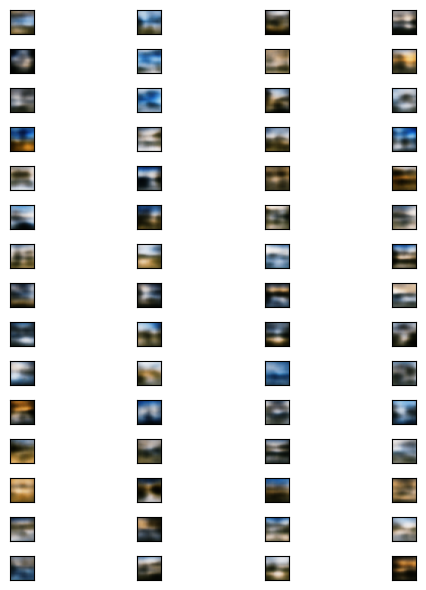

In [ ]:
import math
import os
import matplotlib.pyplot as plt
import zipfile
import io

def show_images(images, titles=None, save_path=None):
    num_images = len(images)
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(6, 6))
    image_paths = []  # To store paths of saved images
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        if titles and len(titles) > i:  # Check if titles are provided and if it has enough elements
            plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

        # Save each image if save_path is provided
        if save_path:
            image_filename = f"image_{i+1}.png"
            image_filepath = os.path.join(save_path, image_filename)
            plt.savefig(image_filepath)
            image_paths.append(image_filepath)

    plt.tight_layout()
    plt.show()

    return image_paths

# Example usage:
# Assuming y_pred is a list of images and os.getcwd() returns the current working directory
image_paths = show_images(y_pred, titles=None, save_path=os.getcwd())

# Create a zip file
with zipfile.ZipFile('images.zip', 'w') as zipf:
    for image_path in image_paths:
        zipf.write(image_path, os.path.basename(image_path))


In [ ]:
from google.colab import files
!zip -r /content.zip /content
#files.download("content.zip")

Streaming output truncated to the last 5000 lines.
updating: content/photo_jpg/57e301422d.jpg (deflated 2%)
updating: content/photo_jpg/a5af8b893b.jpg (deflated 1%)
updating: content/photo_jpg/586d359437.jpg (deflated 2%)
updating: content/photo_jpg/571325ea85.jpg (deflated 1%)
updating: content/photo_jpg/ff769c35c9.jpg (deflated 1%)
updating: content/photo_jpg/4263de0622.jpg (deflated 1%)
updating: content/photo_jpg/174ded9426.jpg (deflated 1%)
updating: content/photo_jpg/76b398536a.jpg (deflated 1%)
updating: content/photo_jpg/ff2cb6658c.jpg (deflated 1%)
updating: content/photo_jpg/5852bbcf34.jpg (deflated 2%)
updating: content/photo_jpg/93d77f649a.jpg (deflated 1%)
updating: content/photo_jpg/2971c7ed92.jpg (deflated 1%)
updating: content/photo_jpg/4b0db938a7.jpg (deflated 2%)
updating: content/photo_jpg/ec2819dd4a.jpg (deflated 4%)
updating: content/photo_jpg/cd002af052.jpg (deflated 2%)
updating: content/photo_jpg/2881c907bb.jpg (deflated 2%)
updating: content/photo_jpg/20ea20410